# Final Submission - Surya Roshan M

## Loading the data

In [315]:
import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix

In [316]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# You can edit the code here to download only once, and not download it later                
#download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
#download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [317]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [318]:
display(comments.head(100))

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...
1185345,NEWLINE_TOKENNEWLINE_TOKEN::Thanks. While I'm ...,2003,True,article,random,test
1212997,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2003,True,user,random,dev
1220372,NEWLINE_TOKENNEWLINE_TOKENWikipedia is banned?...,2003,True,article,random,test


#### Answer d.
I considered a comment as attack if the majority of the annotators consider it to be an attack. Majority is considered by checking if the mean of scores by annotators is more than 0.5 (or 50% plus)

In [319]:
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [320]:
comments['attack'] = labels
display(comments.head())
#uncomment below to view the raw comments file clearly in csv format
#comments.to_csv("raw_comments.csv")

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


In [321]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115864 entries, 37675 to 699897151
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    115864 non-null  object
 1   year       115864 non-null  int64 
 2   logged_in  115864 non-null  bool  
 3   ns         115864 non-null  object
 4   sample     115864 non-null  object
 5   split      115864 non-null  object
 6   attack     115864 non-null  bool  
dtypes: bool(2), int64(1), object(4)
memory usage: 5.5+ MB


## Preprocessing the data 

#### Answer b. 
Text cleaning I performed was remove websites links, extra spaces, any digits, remove punctuations, remove all leading and internal spaces.
This gave a increase of 1% for the decision classifier in the strawman code. 
The conversion to lowercase is done through the countvectorizer so I didnt apply it here. 

In [322]:
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
comments['comment']=comments['comment'].apply(lambda x: x.replace("`"," "))
comments['comment']=comments['comment'].apply(lambda x: x.replace("."," "))
#comments['comment']=comments['comment'].apply(lambda x: x.lower())
import re
comments['comment']=comments['comment'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x))
comments['comment']=comments['comment'].apply(lambda s : re.sub(r'[^\w\s]','',s))
comments['comment']=comments['comment'].apply(lambda x:  re.sub("\S*\d\S*", "", x).strip())

comments['comment']=comments['comment'].apply(lambda x: re.sub(r'\s+'," ",x))


In [323]:
display(comments.head(100))

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,This is not creative Those are the dictionary ...,2002,False,article,random,train,False
44816,the term standard model is itself less NPOV th...,2002,False,article,random,train,False
49851,True or false the situation as of March was su...,2002,False,article,random,train,False
89320,Next maybe you could work on being less condes...,2002,True,article,random,dev,False
93890,This page will need disambiguation,2002,True,article,random,train,False
...,...,...,...,...,...,...,...
1185345,Thanks While Im attemtping without any trainin...,2003,True,article,random,test,False
1212997,Hi Sannse I answered you question on the talkW...,2003,True,user,random,dev,False
1220372,Wikipedia is banned Why,2003,True,article,random,test,False


## Data Visualization and Analysis
 

#### Answer a.

What did I learn by visualizing the data.
I found out that, the data is extremely clean- no missing data or wrong values in fields. Only the comment field requires some cleaning. 
I found out that all the fields are categorical except for year. 
The data is extremely imbalanced, false class has 7.5 times the data of the True class. So using simple accuracy as a metric would not be a good idea. 

The comment column obviously affects the output classification significantly. The task now is to identify which of the other fields affect classification as well.

The fields considered are year, logged_in and ns. 
The heatmap shows that year does not affect the 'attack'. Logged_in and ns show 0.24 and 0.2. Not significant but perhaps considerable.
To further explore the effect of these 2 fields. The proportion of false and true attacks for each of unique values of the fields I considered. 
So a "ratio=[(field_attack/field_not_attack)/(attack_count[True]/attack_count[False])]" is considered. This gives the a ratio which is basically ratio of true's and false's for each class divided with ratio of attack(overall true & false ratio) distribution.

This shows that number of attacks when not logged in is 2.5 times more than non attacks. Logging in gave 1/2 less times attacks than not attacks.
Similarly for ns = user had 1.6 times attacks than non attacks and ns=article had 0.35 times attacks than non attacks. Similarly for each value of year, the ratio was around 1 so that means that field did not affect output distribution so can be ignored.


In [324]:
for field in comments.columns:
    if(field=='comment'):
        continue
    print(field,':\n',comments[field].value_counts(),"\n-----------------")

year :
 2006    17376
2008    16641
2007    16437
2009    12574
2010    10741
2011     8644
2012     7551
2015     6697
2014     6655
2013     6449
2005     4965
2004      640
2016      291
2003      148
2002       48
2001        7
Name: year, dtype: int64 
-----------------
logged_in :
 True     84918
False    30946
Name: logged_in, dtype: int64 
-----------------
ns :
 user       64547
article    51317
Name: ns, dtype: int64 
-----------------
sample :
 blocked    78372
random     37492
Name: sample, dtype: int64 
-----------------
split :
 train    69526
test     23178
dev      23160
Name: split, dtype: int64 
-----------------
attack :
 False    102274
True      13590
Name: attack, dtype: int64 
-----------------


<AxesSubplot:>

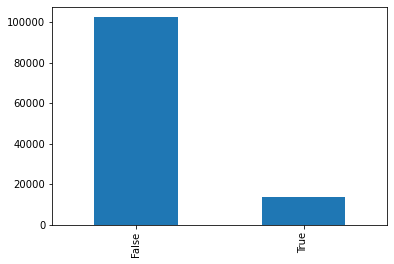

In [364]:
comments['attack'].value_counts().plot(kind='bar',)

<AxesSubplot:>

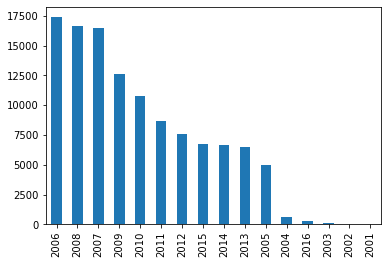

In [325]:
comments['year'].value_counts().plot(kind='bar')

<AxesSubplot:>

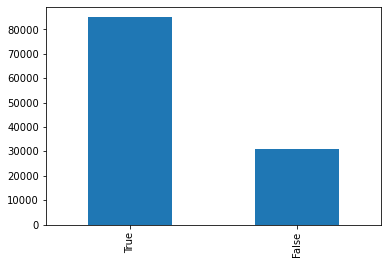

In [326]:
comments['logged_in'].value_counts().plot(kind='bar')

<AxesSubplot:>

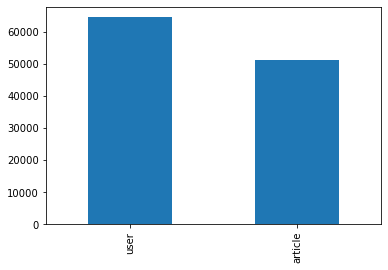

In [327]:
comments['ns'].value_counts().plot(kind='bar')

In [328]:
comments.dtypes
# Uncomment below to view the comments in csv files
#comments.to_csv("comments.csv")

comment      object
year          int64
logged_in      bool
ns           object
sample       object
split        object
attack         bool
dtype: object

#### One hot encoding for heatmap

In [329]:
x=y=None
data=comments
display(comments)
encode=['ns','sample','year']
x=data.iloc[:,1:-1]
y=data.iloc[:,-1]

for enc in encode:
    x[enc]=x[enc].astype('category')
    x=x.join(pd.get_dummies(x[enc]))
data=x.join(y)
data = data.drop(columns=['split'])
data

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,This is not creative Those are the dictionary ...,2002,False,article,random,train,False
44816,the term standard model is itself less NPOV th...,2002,False,article,random,train,False
49851,True or false the situation as of March was su...,2002,False,article,random,train,False
89320,Next maybe you could work on being less condes...,2002,True,article,random,dev,False
93890,This page will need disambiguation,2002,True,article,random,train,False
...,...,...,...,...,...,...,...
699848324,These sources dont exactly exude a sense of im...,2016,True,article,blocked,train,False
699851288,The Institute for Historical Review is a peerr...,2016,True,article,blocked,test,False
699857133,The way youre trying to describe it in this ar...,2016,True,article,blocked,train,False


,year,logged_in,ns,sample,article,user,blocked,random,2001,2002,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,attack
rev_id,,,,,,,,,,,,,,,,,,,,,
37675,2002,False,article,random,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,False
44816,2002,False,article,random,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,False
49851,2002,False,article,random,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,False
89320,2002,True,article,random,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,False
93890,2002,True,article,random,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699848324,2016,True,article,blocked,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,False
699851288,2016,True,article,blocked,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,False
699857133,2016,True,article,blocked,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,False


In [330]:
display(comments)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,This is not creative Those are the dictionary ...,2002,False,article,random,train,False
44816,the term standard model is itself less NPOV th...,2002,False,article,random,train,False
49851,True or false the situation as of March was su...,2002,False,article,random,train,False
89320,Next maybe you could work on being less condes...,2002,True,article,random,dev,False
93890,This page will need disambiguation,2002,True,article,random,train,False
...,...,...,...,...,...,...,...
699848324,These sources dont exactly exude a sense of im...,2016,True,article,blocked,train,False
699851288,The Institute for Historical Review is a peerr...,2016,True,article,blocked,test,False
699857133,The way youre trying to describe it in this ar...,2016,True,article,blocked,train,False


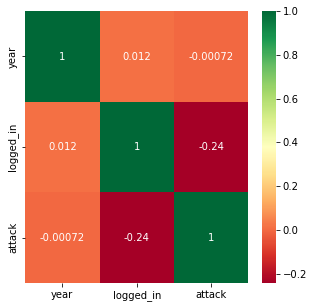

In [331]:
import seaborn as sns
import matplotlib.pyplot as plt

#data= comments


#get correlations of each features in dataset
corrmat = comments.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map
g=sns.heatmap(comments[top_corr_features].corr(),annot=True,cmap="RdYlGn")

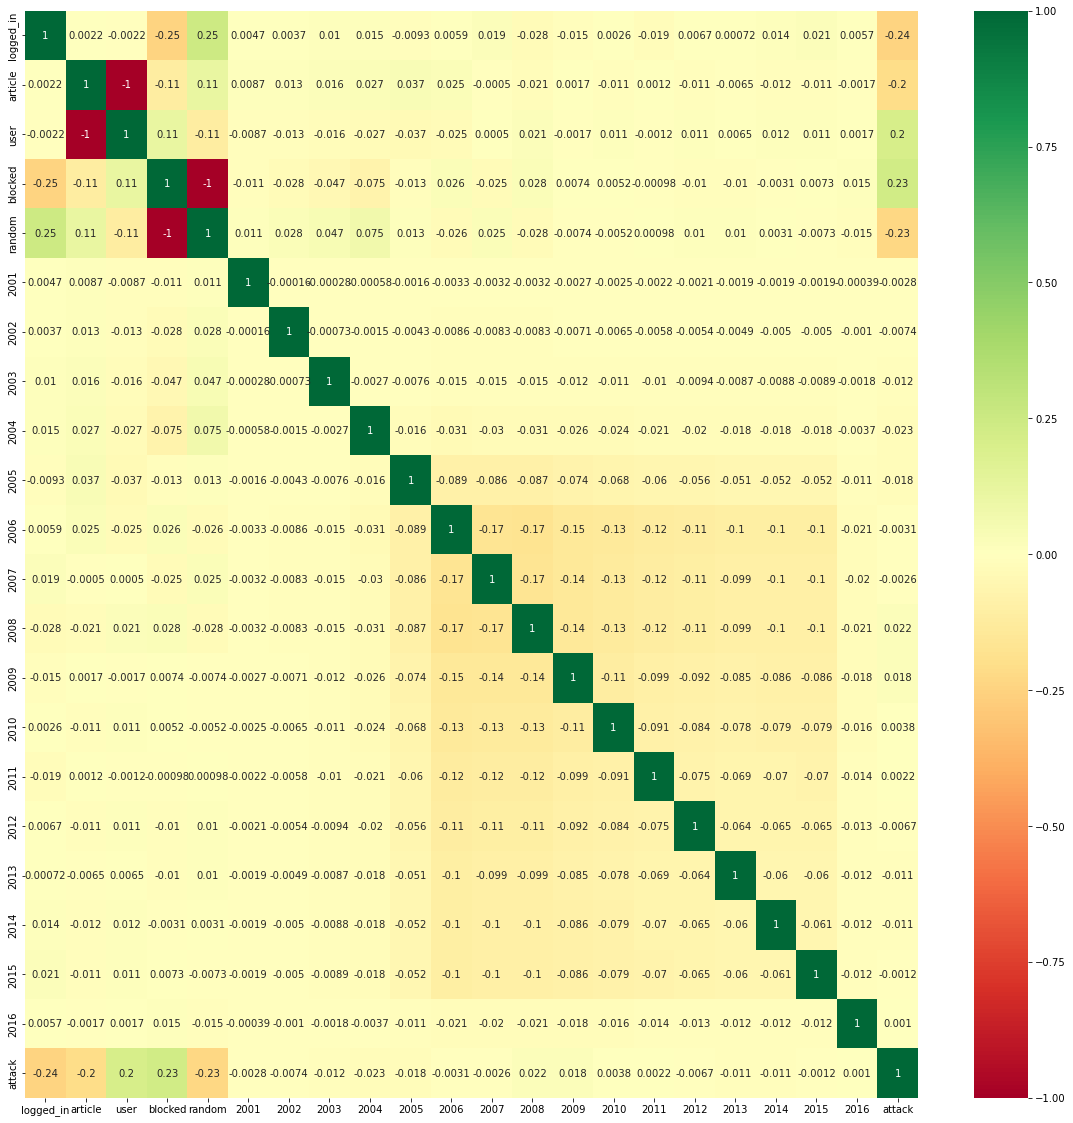

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt

#data= comments

X = data.iloc[:,:-1]  #independent columns

y = data.iloc[:,-1]    #target column - attack

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [333]:
from sklearn.preprocessing import LabelEncoder
data=comments.copy()
encode=['ns','sample']
for x in encode:
    data[x]=LabelEncoder().fit_transform(data[x])
display(data)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,This is not creative Those are the dictionary ...,2002,False,0,1,train,False
44816,the term standard model is itself less NPOV th...,2002,False,0,1,train,False
49851,True or false the situation as of March was su...,2002,False,0,1,train,False
89320,Next maybe you could work on being less condes...,2002,True,0,1,dev,False
93890,This page will need disambiguation,2002,True,0,1,train,False
...,...,...,...,...,...,...,...
699848324,These sources dont exactly exude a sense of im...,2016,True,0,0,train,False
699851288,The Institute for Historical Review is a peerr...,2016,True,0,0,test,False
699857133,The way youre trying to describe it in this ar...,2016,True,0,0,train,False


#### Checking how each value of a field affects the output

#### If ratio closer to 1 then that field doesnt really affect the output

In [335]:
# print total distribution of attacks and non attacks
attack_count=data['attack'].value_counts()
print(attack_count)
#
print('\nattack = true per year')
year_attack=data.query('attack')['year'].value_counts()
print(year_attack)
print('\nattack = false per year')
year_not_attack=data.query('not attack')['year'].value_counts()
print(year_not_attack)

for year,value in year_attack.items():
    
    ratio=(year_attack[year]/year_not_attack[year])/(attack_count[True]/attack_count[False])
    print(year, 'ratio=', ratio)

False    102274
True      13590
Name: attack, dtype: int64

attack = true per year
2008    2239
2006    1997
2007    1894
2009    1683
2010    1301
2011    1035
2012     824
2015     775
2014     688
2013     661
2005     445
2016      36
2004      11
2003       1
Name: year, dtype: int64

attack = false per year
2006    15379
2007    14543
2008    14402
2009    10891
2010     9440
2011     7609
2012     6727
2014     5967
2015     5922
2013     5788
2005     4520
2004      629
2016      255
2003      147
2002       48
2001        7
Name: year, dtype: int64
2008 ratio= 1.1699763206381584
2006 ratio= 0.9772276645508353
2007 ratio= 0.9801030837125214
2009 ratio= 1.1629529455331304
2010 ratio= 1.0371727248350606
2011 ratio= 1.023666640846192
2012 ratio= 0.9218315524853278
2015 ratio= 0.9848703988246518
2014 ratio= 0.8677171586231015
2013 ratio= 0.8594462522495858
2005 ratio= 0.7409132495913835
2016 ratio= 1.0624490325931697
2004 ratio= 0.1316096774608656
2003 ratio= 0.051195106445816


#### For NS and Logged in, the ratio is far from 1, making it worthy of exploration. The end results show that they help in improving the accuracy by 0.6% which is not significant but nevertheless an improvement

In [336]:
# print total distribution of attacks and non attacks
data=comments.copy()
attack_count=data['attack'].value_counts()
print(attack_count)
#
print('\nattack = true for ns')
year_attack=data.query('attack')['ns'].value_counts()
print(year_attack)
print('\nattack = false for ns')
year_not_attack=data.query('not attack')['ns'].value_counts()
print(year_not_attack)

for year,value in year_attack.items():
    
    ratio=(year_attack[year]/year_not_attack[year])/(attack_count[True]/attack_count[False])
    print(year, 'ratio=', ratio)

False    102274
True      13590
Name: attack, dtype: int64

attack = true for ns
user       11341
article     2249
Name: ns, dtype: int64

attack = false for ns
user       53206
article    49068
Name: ns, dtype: int64
user ratio= 1.6041187878001333
article ratio= 0.34493469830248036


In [337]:
# print total distribution of attacks and non attacks
data=comments.copy()
attack_count=data['attack'].value_counts()
print(attack_count)
#
print('\nattack = true per logged_in')
year_attack=data.query('attack')['logged_in'].value_counts()
print(year_attack)
print('\nattack = false per logged_in')
year_not_attack=data.query('not attack')['logged_in'].value_counts()
print(year_not_attack)

print('If ratio near one then it equally distributes data, else major difference then this field effects the data')
for year,value in year_attack.items():
    
    ratio=(year_attack[year]/year_not_attack[year])/(attack_count[True]/attack_count[False])
    print(year, 'ratio=', ratio)

False    102274
True      13590
Name: attack, dtype: int64

attack = true per logged_in
False    7635
True     5955
Name: logged_in, dtype: int64

attack = false per logged_in
True     78963
False    23311
Name: logged_in, dtype: int64
If ratio near one then it equally distributes data, else major difference then this field effects the data
False ratio= 2.4648694497846235
True ratio= 0.5675497163997142


#### Answer to e. 

Optimizations I did were to not preprocess the data for lowercase and let the tfidfvectorizer do it.
Another optimization that I performed was to do one hot encoding for the entire data before training the model. This was to reduce the amount of the times data would get transformed for each iteration in a K fold Cross validation. This would skip the need to do one hot transformation at the time of Hypertuning parameters. 

Finally, I used n_jobs=-1 to ensure parallelization of my model training. 

#### Drop fields that are not needed and convert the other fields into one hot encoding

In [339]:
x=y=None
data=comments
#display(comments)
#encode=['ns','logged_in']
encode=['ns','logged_in']
x=data.iloc[:,2:4]
y=data.iloc[:,-1]
#print(x)
for enc in encode:
    x[enc]=x[enc].astype('category')
    x=x.join(pd.get_dummies(x[enc],prefix=enc))
    #print(x)
data=x.join(y)
#display(data)
#data = data.drop(columns=['split'])
data=data.drop(columns=encode)
display(data)

,ns_article,ns_user,logged_in_False,logged_in_True,attack
rev_id,,,,,
37675,1,0,1,0,False
44816,1,0,1,0,False
49851,1,0,1,0,False
89320,1,0,0,1,False
93890,1,0,0,1,False
...,...,...,...,...,...
699848324,1,0,0,1,False
699851288,1,0,0,1,False
699857133,1,0,0,1,False


In [340]:
X= pd.DataFrame(comments['comment'])
X=X.join(data)
y=comments['attack']
final_data=X
final_data.dtypes

comment            object
ns_article          uint8
ns_user             uint8
logged_in_False     uint8
logged_in_True      uint8
attack               bool
dtype: object

In [341]:
display(final_data)
final_data.to_csv("final_comments_data.csv")

,comment,ns_article,ns_user,logged_in_False,logged_in_True,attack
rev_id,,,,,,
37675,This is not creative Those are the dictionary ...,1,0,1,0,False
44816,the term standard model is itself less NPOV th...,1,0,1,0,False
49851,True or false the situation as of March was su...,1,0,1,0,False
89320,Next maybe you could work on being less condes...,1,0,0,1,False
93890,This page will need disambiguation,1,0,0,1,False
...,...,...,...,...,...,...
699848324,These sources dont exactly exude a sense of im...,1,0,0,1,False
699851288,The Institute for Historical Review is a peerr...,1,0,0,1,False
699857133,The way youre trying to describe it in this ar...,1,0,0,1,False


#### Answer c.

The features included are Comments, ns, Logged_in. The labels are attack. I considered using these 3 and observed that the main contributor to classify output is comments but logged_in and ns help in improving the macro average score by a mere 0.5%, nevertheless I considered to use it in the final code. 

## K Cross Validation

In [342]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [343]:
def kCrossValidation(clf,comments):
    kf=KFold(n_splits=10)
    oversample = RandomOverSampler(sampling_strategy='minority')
    undersample= RandomUnderSampler()

    X=comments.iloc[:,:-1]
    y=comments['attack']

    score_array =[]
    confusion_matrix_array=[]
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #Uncomment below to use over sampling.
        #X_train_upsample, y_train_upsample = oversample.fit_resample(X_train.to_frame(name='comment'),y_train)
        #X_train_upsample, y_train_upsample = undersample.fit_resample(X_train.to_frame(name='comment'),y_train)
        #trained_clf=clf.fit(X_train_upsample['comment'],y_train_upsample)
        
        #below is for imbalanced
        print(y_train.value_counts())
               
        trained_clf=clf.fit(X_train,y_train)
        
        
        y_pred = trained_clf.predict(X_test)
        score_array.append(metrics.classification_report(y_test, y_pred,output_dict=True))
        confusion_matrix_array.append(confusion_matrix(y_test,y_pred))
        
    return score_array,confusion_matrix_array
    

### Getting the necessary scoring metrics from all K folds

#### Answer h.

Different metrics showed me that simply checking accuracy is not a good idea due to the imbalances in data.

One should look at different metrics which give higher importance to the data belonging to minor class. 

Also learned the precision and recall both should be considered together instead of looking at only one. Since either of them is easy to get high but the model will not work as expected. 

This paved the way to use macro averaged F1 score. (for k fold , I used average of macro average F1 score over all models)

Cross validation proved to be very useful to understand the standard deviations in model's performance and gave an overview of how the model would work for that data and cancels the randomness of train test split.

#### code to get average over scores of k iterations 

In [344]:
from collections import defaultdict
def getAverage(score,type_Avg):
    avgs=defaultdict(lambda: list())

    #print(score)
    for report in score:
        display(pd.DataFrame(report).transpose())
        #print(report['macro avg'].keys())
        for key in report[type_Avg].keys():

            avgs[key].append(report[type_Avg][key])
    #print(avgs)
    for key in avgs.keys():
        print("average",key,"=",sum(avgs[key])/len(avgs[key]))

In [345]:
def getAccuracyAverage(score):
    avgs=[]
    for report in score:
        avgs.append(report['accuracy'])
    
    print(sum(avgs)/len(avgs))
    

### Running the model with k cross validation

#### Answer to f.

Machine Learning models tried out:
    
Decision Tree
        -with word n_gram (1,2), char n gram (1,10), 10 fold cross validation with imbalanced data and balanced.
        
        - Best model : 10 fold cross validation with balanced 79%

Logistic regression:
        - with word n_gram(1,2) (1,1) , weights:balanced(train_test_split), 10 fold balanced and imbalanced. 
        
        - Best model : Logistic regression with macro average - 84.3% for imbalanced (1,1)
        
Multinomial Naive Bayes:
        - train_Test, k fold imbalanced and balanced
        
        - Best Model : Imbalanced k fold macro average - 81%
        
Random Forest:
        - train_test, K fold balanced and imbalanced
        
        - Best model : Imbalanced k fold macro average - 81.5%

Linear SVC:
        - train_test, (1,2) and (1,1) word n gram with 10 fold cross validation for balanced and imbalanced
        
        - Best model : unigram 10 fold cross validation with macro average :85.7% 

Ridge Classifier :
        - word ngram(1,2) with 10 fold cross validation with balanced data and imbalanced
        
        - best model : 10 fold cross validation with imbalanced : 82%

SDG Classifier :
        - word ngram(1,2) with 10 fold cross validation with imbalanced data 
        
        - best model : 10 fold cross validation with imbalanced : 79.4%

Passive Aggressive Classifier:
        - word ngram(1,2) with 10 fold cross validation with imbalanced data 
        
        - best model: 10 fold cross validation with imbalance : 79.4%

Perceptron :
        - word ngram(1,2) with 10 fold cross validation with imbalanced data 
        
        - best model: 10 fold cross validation with imbalance : 81.2%


Best ML model before hyper parameter tuning : Linear SVC. Also, Logistic Regression showed very similar results so I decided to perform hyper parameter tuning on both of them

### LinearSVC

In [359]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

column=ColumnTransformer(
    transformers=[       
        ("tfidf", TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2'), 'comment'),
    ],remainder='passthrough',
)

clf = Pipeline([
    ('preprocess',column),
    ('clf',LinearSVC())
])
score,confusion=kCrossValidation(clf,final_data)

False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [360]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
print(confusion)


,precision,recall,f1-score,support
False,0.963316,0.987091,0.975059,10535.000000
True,0.828283,0.623574,0.711497,1052.000000
accuracy,0.954086,0.954086,0.954086,0.954086
macro avg,0.895800,0.805332,0.843278,11587.000000
weighted avg,0.951056,0.954086,0.951129,11587.000000


,precision,recall,f1-score,support
False,0.951382,0.983702,0.967272,10185.000000
True,0.842803,0.634807,0.724166,1402.000000
accuracy,0.941486,0.941486,0.941486,0.941486
macro avg,0.897092,0.809254,0.845719,11587.000000
weighted avg,0.938244,0.941486,0.937856,11587.000000


,precision,recall,f1-score,support
False,0.959806,0.986811,0.973121,10236.000000
True,0.873001,0.686899,0.768848,1351.000000
accuracy,0.951843,0.951843,0.951843,0.951843
macro avg,0.916404,0.836855,0.870985,11587.000000
weighted avg,0.949685,0.951843,0.949304,11587.000000


,precision,recall,f1-score,support
False,0.953329,0.986303,0.969536,10148.000000
True,0.872243,0.659486,0.751088,1439.000000
accuracy,0.945715,0.945715,0.945715,0.945715
macro avg,0.912786,0.822894,0.860312,11587.000000
weighted avg,0.943259,0.945715,0.942406,11587.000000


,precision,recall,f1-score,support
False,0.951762,0.980600,0.965966,10000.000000
True,0.848792,0.686633,0.759150,1586.000000
accuracy,0.940359,0.940359,0.940359,0.940359
macro avg,0.900277,0.833617,0.862558,11586.000000
weighted avg,0.937666,0.940359,0.937655,11586.000000


,precision,recall,f1-score,support
False,0.953219,0.982662,0.967717,10036.000000
True,0.859677,0.687742,0.764158,1550.000000
accuracy,0.943207,0.943207,0.943207,0.943207
macro avg,0.906448,0.835202,0.865937,11586.000000
weighted avg,0.940704,0.943207,0.940484,11586.000000


,precision,recall,f1-score,support
False,0.957572,0.984161,0.970685,10228.000000
True,0.849162,0.671576,0.750000,1358.000000
accuracy,0.947523,0.947523,0.947523,0.947523
macro avg,0.903367,0.827868,0.860342,11586.000000
weighted avg,0.944865,0.947523,0.944818,11586.000000


,precision,recall,f1-score,support
False,0.956988,0.984085,0.970348,10242.000000
True,0.845351,0.662946,0.743119,1344.000000
accuracy,0.946832,0.946832,0.946832,0.946832
macro avg,0.901170,0.823516,0.856733,11586.000000
weighted avg,0.944038,0.946832,0.943989,11586.000000


,precision,recall,f1-score,support
False,0.963653,0.985840,0.974620,10381.000000
True,0.847826,0.679668,0.754491,1205.000000
accuracy,0.953996,0.953996,0.953996,0.953996
macro avg,0.905740,0.832754,0.864556,11586.000000
weighted avg,0.951607,0.953996,0.951726,11586.000000


,precision,recall,f1-score,support
False,0.955415,0.985705,0.970324,10283.000000
True,0.849539,0.636992,0.728070,1303.000000
accuracy,0.946487,0.946487,0.946487,0.946487
macro avg,0.902477,0.811348,0.849197,11586.000000
weighted avg,0.943508,0.946487,0.943079,11586.000000


average precision = 0.9041559909614441
average recall = 0.8238640835340343
average f1-score = 0.8579616263427816
average support = 11586.4
0.9471535203674076
[array([[10399,   136],
       [  396,   656]], dtype=int64), array([[10019,   166],
       [  512,   890]], dtype=int64), array([[10101,   135],
       [  423,   928]], dtype=int64), array([[10009,   139],
       [  490,   949]], dtype=int64), array([[9806,  194],
       [ 497, 1089]], dtype=int64), array([[9862,  174],
       [ 484, 1066]], dtype=int64), array([[10066,   162],
       [  446,   912]], dtype=int64), array([[10079,   163],
       [  453,   891]], dtype=int64), array([[10234,   147],
       [  386,   819]], dtype=int64), array([[10136,   147],
       [  473,   830]], dtype=int64)]


### Logistic Regression

In [350]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
#transformer_numeric = FunctionTransformer(get_numeric_data)
#transformer_text = FunctionTransformer(get_text_data)

column=ColumnTransformer(
    transformers=[
       # ("num", numeric_transformer, numeric_features),
        ("tfidf", TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2'), 'comment'),
    ],remainder='passthrough',
)


clf = Pipeline([
    ('preprocess',column),
    ('clf',LogisticRegression(max_iter=1000))
])
score,confusion=kCrossValidation(clf,final_data)

False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [351]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
print(confusion)

,precision,recall,f1-score,support
False,0.957459,0.991267,0.974070,10535.000000
True,0.864706,0.558935,0.678984,1052.000000
accuracy,0.952015,0.952015,0.952015,0.952015
macro avg,0.911082,0.775101,0.826527,11587.000000
weighted avg,0.949037,0.952015,0.947278,11587.000000


,precision,recall,f1-score,support
False,0.944236,0.989200,0.966195,10185.000000
True,0.880044,0.575606,0.695990,1402.000000
accuracy,0.939156,0.939156,0.939156,0.939156
macro avg,0.912140,0.782403,0.831092,11587.000000
weighted avg,0.936469,0.939156,0.933501,11587.000000


,precision,recall,f1-score,support
False,0.955068,0.990524,0.972473,10236.000000
True,0.900103,0.646928,0.752799,1351.000000
accuracy,0.950462,0.950462,0.950462,0.950462
macro avg,0.927585,0.818726,0.862636,11587.000000
weighted avg,0.948659,0.950462,0.946860,11587.000000


,precision,recall,f1-score,support
False,0.945124,0.989456,0.966782,10148.000000
True,0.888889,0.594858,0.712739,1439.000000
accuracy,0.940451,0.940451,0.940451,0.940451
macro avg,0.917007,0.792157,0.839761,11587.000000
weighted avg,0.938140,0.940451,0.935232,11587.000000


,precision,recall,f1-score,support
False,0.946877,0.983900,0.965034,10000.00000
True,0.865272,0.651955,0.743617,1586.00000
accuracy,0.938460,0.938460,0.938460,0.93846
macro avg,0.906075,0.817927,0.854325,11586.00000
weighted avg,0.935706,0.938460,0.934724,11586.00000


,precision,recall,f1-score,support
False,0.944455,0.986050,0.964805,10036.000000
True,0.873646,0.624516,0.728367,1550.000000
accuracy,0.937683,0.937683,0.937683,0.937683
macro avg,0.909051,0.805283,0.846586,11586.000000
weighted avg,0.934982,0.937683,0.933173,11586.000000


,precision,recall,f1-score,support
False,0.952587,0.988072,0.970005,10228.000000
True,0.875128,0.629602,0.732334,1358.000000
accuracy,0.946056,0.946056,0.946056,0.946056
macro avg,0.913858,0.808837,0.851170,11586.000000
weighted avg,0.943508,0.946056,0.942148,11586.000000


,precision,recall,f1-score,support
False,0.951951,0.988479,0.969871,10242.00000
True,0.875920,0.619792,0.725926,1344.00000
accuracy,0.945710,0.945710,0.945710,0.94571
macro avg,0.913936,0.804135,0.847899,11586.00000
weighted avg,0.943131,0.945710,0.941573,11586.00000


,precision,recall,f1-score,support
False,0.956327,0.989307,0.972538,10381.00000
True,0.868949,0.610788,0.717349,1205.00000
accuracy,0.949940,0.949940,0.949940,0.94994
macro avg,0.912638,0.800048,0.844943,11586.00000
weighted avg,0.947240,0.949940,0.945997,11586.00000


,precision,recall,f1-score,support
False,0.950028,0.989108,0.969174,10283.000000
True,0.872727,0.589409,0.703619,1303.000000
accuracy,0.944157,0.944157,0.944157,0.944157
macro avg,0.911378,0.789259,0.836397,11586.000000
weighted avg,0.941335,0.944157,0.939309,11586.000000


average precision = 0.9134748477767511
average recall = 0.7993876444627998
average f1-score = 0.8441335458082173
average support = 11586.4
0.9444089238445599
[array([[10443,    92],
       [  464,   588]], dtype=int64), array([[10075,   110],
       [  595,   807]], dtype=int64), array([[10139,    97],
       [  477,   874]], dtype=int64), array([[10041,   107],
       [  583,   856]], dtype=int64), array([[9839,  161],
       [ 552, 1034]], dtype=int64), array([[9896,  140],
       [ 582,  968]], dtype=int64), array([[10106,   122],
       [  503,   855]], dtype=int64), array([[10124,   118],
       [  511,   833]], dtype=int64), array([[10270,   111],
       [  469,   736]], dtype=int64), array([[10171,   112],
       [  535,   768]], dtype=int64)]


# Hyperparameter tuning

#### Answer g.

Hyperparameter tuning performed for LinearSVC and Logistic regression.


For Logistic Regression: unigrams and bigrams
        
        - class weight :[{False:1,True:1},{False:1,True:2},{False:1,True:3},{False:1,True:4},'balanced'],
        
        - C: 0.1 , 1, 10
        
        - solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
        
For linearSVC with only unigrams:
        
        - class weight : [{False:1,True:1},{False:1,True:2},{False:1,True:3},{False:1,True:4},'balanced'],
        
        - C: [0.1,1]
        
        - loss: hinge, square hinge

Improvement for LinearSVC: 85.7 to 86.82 (nearly 1.1%)
Improvement for Logistic Regression : 84.4 to 86.1(1.7%)

Only documenting the hyperparameter tuning for LinearSVC with unigrams

### Hyperparameter tuning for linearSVC

In [356]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
#transformer_numeric = FunctionTransformer(get_numeric_data)
#transformer_text = FunctionTransformer(get_text_data)
X=final_data.iloc[:,:-1]
Y=final_data['attack']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    train_size=0.80,
                                                    test_size=0.20,
                                                    random_state=12)

column=ColumnTransformer(
    transformers=[
       # ("num", numeric_transformer, numeric_features),
        ("tfidf", TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2'), 'comment'),
    ],remainder='passthrough',
)

parameter={
    'clf__class_weight':[{False:1,True:1},{False:1,True:2},{False:1,True:3},{False:1,True:4},'balanced'],
    #'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__C':[0.1, 1],
    'clf__loss':['hinge', 'squared_hinge']
}
clf = Pipeline([
    ('preprocess',column),
    ('clf',LinearSVC(max_iter=10000))
])
grid=GridSearchCV(clf,param_grid=parameter,scoring='f1_macro',verbose=50,n_jobs=-1)
grid.fit(X_train, Y_train)

print('\nBest R^2 Score : %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))



Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best R^2 Score : 0.87  Best Params :  {'clf__C': 1, 'clf__class_weight': {False: 1, True: 2}, 'clf__loss': 'hinge'}


#### Answer to i.
The metrics for my best result are Macro avg: 87% , precision: 88%, recall: 86%.

The metric is LinearSVC with unigrams for tfidf transformer and classifier parameters are C:1, class_weight: {False:1, True:2}, loss:hinge.

The increase in accuracy compared to strawman code is from 79% to 87% (nearly 8% improvement)

In [357]:
display(pd.DataFrame(grid.cv_results_))
Y_pred=grid.best_estimator_.predict(X_test)
print((metrics.classification_report(Y_test,Y_pred)))
print(metrics.confusion_matrix(Y_test,Y_pred))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.803255,0.932123,3.414477,0.127990,0.1,"{False: 1, True: 1}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.798986,0.795074,0.800655,0.790995,0.794837,0.796109,0.003400,20
1,16.476062,0.478505,3.859278,0.319116,0.1,"{False: 1, True: 1}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.842640,0.838973,0.845479,0.834029,0.842322,0.840689,0.003917,15
2,16.522436,0.836997,3.768521,0.239737,0.1,"{False: 1, True: 2}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.852354,0.848216,0.852423,0.844545,0.853596,0.850227,0.003377,13
3,15.644656,0.287497,4.093653,0.131314,0.1,"{False: 1, True: 2}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.867325,0.867011,0.867397,0.859380,0.866659,0.865554,0.003098,3
4,18.545016,1.921591,3.531480,0.140064,0.1,"{False: 1, True: 3}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.867704,0.862691,0.868806,0.857412,0.864254,0.864174,0.004046,4
5,16.277619,0.633043,3.955046,0.240546,0.1,"{False: 1, True: 3}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.866174,0.867386,0.868947,0.861659,0.864600,0.865753,0.002496,2
6,16.257696,0.512244,3.498448,0.178529,0.1,"{False: 1, True: 4}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.859440,0.858364,0.863552,0.854837,0.858123,0.858863,0.002805,8
7,16.946419,0.378031,3.417104,0.176960,0.1,"{False: 1, True: 4}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.862293,0.862108,0.865233,0.856940,0.859660,0.861247,0.002785,6
8,16.998670,0.666538,3.926290,0.404314,0.1,balanced,hinge,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.822338,0.819818,0.824343,0.811921,0.817936,0.819271,0.004272,19
9,17.636956,1.380003,3.576451,0.473214,0.1,balanced,squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.839395,0.836681,0.838727,0.829232,0.832813,0.835370,0.003832,16


              precision    recall  f1-score   support

       False       0.97      0.98      0.97     20458
        True       0.80      0.74      0.76      2715

    accuracy                           0.95     23173
   macro avg       0.88      0.86      0.87     23173
weighted avg       0.95      0.95      0.95     23173

[[19949   509]
 [  718  1997]]


# Summary of Answers

#### Answer a.

What did I learn by visualizing the data. I found out that, the data is extremely clean- no missing data or wrong values in fields. Only the comment field requires some cleaning. I found out that all the fields are categorical except for year. The data is extremely imbalanced, false class has 7.5 times the data of the True class. So using simple accuracy as a metric would not be a good idea.

The comment column obviously affects the output classification significantly. The task now is to identify which of the other fields affect classification as well.

The fields considered are year, logged_in and ns. The heatmap shows that year does not affect the 'attack'. Logged_in and ns show 0.24 and 0.2. Not significant but perhaps considerable. To further explore the effect of these 2 fields. A ratio which is basically ratio of true's and false's for each class divided with ratio of attack(overall true & false ratio) is calculated.

This shows that number of attacks when not logged in is 2.5 times more than non attacks. Logging in gave 1/2 less times attacks than not attacks. Similarly for ns = user had 1.6 times attacks than non attacks and ns=article had 0.35 times attacks than non attacks. For each value of year, the ratio was around 1 so that means that field did not affect output distribution so can be ignored.

===============================================================================================================================

#### Answer b. 
Text cleaning I performed was remove websites links, extra spaces, any digits, remove punctuations, remove all leading and internal spaces.
This gave a increase of 1% for the decision classifier in the strawman code. 
The conversion to lowercase is done through the countvectorizer so I didnt apply it specifically. 


===============================================================================================================================

#### Answer c.

The features included are Comments, ns, Logged_in. The labels are attack. I considered using these 3 and observed that the main contributor to classify output is comments but logged_in and ns help in improving the macro average score by a mere 0.5%, nevertheless I considered to use it in the final code.

===============================================================================================================================

#### Answer d.
I considered a comment as attack if the majority of the annotators consider it to be an attack. Majority is considered by checking if the mean of scores by annotators is more than 0.5 (or 50% plus)


===============================================================================================================================

#### Answer e.

Optimizations I did were to not preprocess the data for lowercase and let the tfidfvectorizer do it. 

Another optimization that I performed was to do one hot encoding for the entire data before training the model. This was to reduce the amount of the times data would get transformed for each iteration in a K fold Cross validation. This would skip the need to do one hot transformation at the time of Hypertuning parameters.

Finally, I used n_jobs=-1 to ensure parallelization of my model training.


===============================================================================================================================

#### Answer to f.

Machine Learning models tried out:
    
Decision Tree
        -with word n_gram (1,2), char n gram (1,10), 10 fold cross validation with imbalanced data and balanced.
        
        - Best model : 10 fold cross validation with balanced 79%

Logistic regression:
        - with word n_gram(1,2) (1,1) , weights:balanced(train_test_split), 10 fold balanced and imbalanced. 
        
        - Best model : Logistic regression with macro average - 84.3% for imbalanced (1,1)
        
Multinomial Naive Bayes:
        - train_Test, k fold imbalanced and balanced
        
        - Best Model : Imbalanced k fold macro average - 81%
        
Random Forest:
        - train_test, K fold balanced and imbalanced
        
        - Best model : Imbalanced k fold macro average - 81.5%

Linear SVC:
        - train_test, (1,2) and (1,1) word n gram with 10 fold cross validation for balanced and imbalanced
        
        - Best model : unigram 10 fold cross validation with macro average :85.7% 

Ridge Classifier :
        - word ngram(1,2) with 10 fold cross validation with balanced data and imbalanced
        
        - best model : 10 fold cross validation with imbalanced : 82%

SDG Classifier :
        - word ngram(1,2) with 10 fold cross validation with imbalanced data 
        
        - best model : 10 fold cross validation with imbalanced : 79.4%

Passive Aggressive Classifier:
        - word ngram(1,2) with 10 fold cross validation with imbalanced data 
        
        - best model: 10 fold cross validation with imbalance : 79.4%

Perceptron :
        - word ngram(1,2) with 10 fold cross validation with imbalanced data 
        
        - best model: 10 fold cross validation with imbalance : 81.2%


===============================================================================================================================

#### Answer g.

Hyperparameter tuning performed for LinearSVC and Logistic regression.

Best ML model before hyper parameter tuning : Linear SVC. Also, Logistic Regression showed very similar results so I decided to perform hyper parameter tuning on both of them

        
For Logistic Regression: 
        
        - class weight :[{False:1,True:1},{False:1,True:2},{False:1,True:3},{False:1,True:4},'balanced'],
        
        - C: 0.1 , 1, 10
        
        - solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
        
        
For linearSVC with only unigrams:
        
        - class weight : [{False:1,True:1},{False:1,True:2},{False:1,True:3},{False:1,True:4},'balanced'],
        
        - C: [0.1,1]
        
        - loss: hinge, square hinge

Improvement for LinearSVC: 85.7 to 86.82 (nearly 1.1%)
Improvement for Logistic Regression : 84.4 to 86.1(1.7%)

===============================================================================================================================

#### Answer h.

Different metrics showed me that simply checking accuracy is not a good idea due to the imbalances in data.

One should look at different metrics which give higher importance to the data belonging to minor class.

Also learned the precision and recall both should be considered together instead of looking at only one. Since either of them is easy to get high but the model will not work as expected.

This paved the way to use macro averaged F1 score. (for k fold , I used average of macro average F1 score over all models)

Cross validation proved to be very useful to understand the standard deviations in model's performance and gave me an overview of how the model would work for that data and cancels the randomness/partiality of train test split.

===============================================================================================================================

#### Answer i.
The metrics for my best result are Macro avg: 87% , precision: 88%, recall: 86%. 

The Best model is LinearSVC with unigrams for tfidf transformer and classifier parameters are C:1, class_weight:{False:1,True:2}, loss:hinge.

The increase in accuracy compared to strawman code is from 79% to 87% (nearly 8% improvement)

===============================================================================================================================

#### Answer j.

Most interesting thing I learned was how much vastness there is to machine learning. There are so many models to try, and various combinations of parameters for those. I really liked how the accuracy increased by making small changes to the parameters.

===============================================================================================================================

#### Answer k. 
Hardest thing to do was to select features. The data analysis needed lot of statistical knowledge, which graph to use and how to understand that. Along with this, deciding whether to include a feature or not (in my case logged in or ns, which might effect the output from one train of thought and data but also seem like they wont with another train of thought).